In [8]:
from pathlib import Path
import pygimli as pg  # Stelle sicher, dass das Modul pg importiert ist und verfügbar ist
from pygimli.physics import ert
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import os
import numpy as np

from Hilfsfunktionen import T_corr_nach_Inversion
from Hilfsfunktionen import plotting_function
from Hilfsfunktionen import plotting_function_FTL

# Read data
file = "two_timesteps_231211_240131.ohm"
two_timesteps = False
base_dir = Path("filtered_data")
data = []
for unterordner in base_dir.iterdir():
    if unterordner.is_dir():
        datei_pfad = unterordner / "two_timesteps_231211_240131.ohm" 
        if datei_pfad.exists():
            daten_objekt = pg.load(str(datei_pfad))
            data.append([unterordner.name, daten_objekt])
            print(f"Load data: {datei_pfad}")

# Create method manager
manager = []
for ts in data:
    manager.append(ert.ERTManager(ts[1], verbose=True))

# Create mesh
mesh = manager[0].createMesh(quality = 34, paraMaxCellSize=0.5, paraDepth=15)
manager[0].invert(quality = 34, paraMaxCellSize=0.5, maxIter=1 ,dPhi= 0.1, paraDepth=15,lam=20)

# Inversion without temperature correction
DATA = [dat[1] for dat in data]
# Full time-lapse
scalef = 0.7
fop = pg.frameworks.MultiFrameModelling(ert.ERTModelling, scalef=scalef)
fop.setData(DATA)
fop.setMesh(mesh)
print(fop.mesh()) 
dataVec = np.concatenate([data["rhoa"] for data in DATA])
errorVec = np.concatenate([data["err"] for data in DATA])
startModel = fop.createStartModel(dataVec)
inv = pg.Inversion(fop=fop, startModel=startModel, verbose=True)
model = inv.run(dataVec, errorVec, maxIter=10, lam= 15, startModel=startModel, verbose=True)
chi2 = []
rrms = []
chi2.append(round(inv.chi2(),2))
rrms.append(round(inv.relrms(),2))
kw = dict(cMin=10, cMax=300, logScale=True, cMap="jet")
pd = fop.paraDomain
mod = np.reshape(model, [len(DATA), -1])

# Temperature correction    
ort_2 = 'Georg-Westermann-Park'
mod_corr = []
temp_spread = []
timestep = 0
mesh2 = manager[0].mesh.createSubMesh(manager[0].mesh.cells(manager[0].mesh.cellMarkers() == 2))
for count, m in enumerate(mod):
    timestep = count+3
    dateien = os.listdir(r".\Temperature_data/" + ort_2 )
    for datei in dateien: 
        if (datei).startswith('T_Profil%s_array' % (str(timestep))):
            print(datei)
            Temp_tiefe_vektor = np.load(r'.\Temperature_data/%s/' % (ort_2) + datei, allow_pickle=True)
    res_new,Tem_new = T_corr_nach_Inversion(m, mesh2, Temp_tiefe_vektor)
    mod_corr.append(res_new)
    temp_spread.append(Tem_new)

modell2 = np.reshape(mod, -1)
modell_corr = np.reshape(mod_corr, -1)
response = inv.fop.response(modell2)
response_t_corr = inv.fop.response(modell_corr)
difference = response_t_corr - response
diff = np.reshape(difference, [len(DATA), -1])
for h in range(len(diff)):
    DATA[h]['rhoa'] = DATA[h]['rhoa'] + diff[h]
    
    
# Inversion with temperature correction
# Full time-lapse
scalef = 0.7
fop = pg.frameworks.MultiFrameModelling(ert.ERTModelling, scalef=scalef)
fop.setData(DATA)
#manager[0].createMesh(quality=34,paraMaxCellSize=20)
fop.setMesh(mesh)
print(fop.mesh())  # important to call mesh() function once!
dataVec = np.concatenate([data["rhoa"] for data in DATA])
errorVec = np.concatenate([data["err"] for data in DATA])
startModel = fop.createStartModel(dataVec)
inv = pg.Inversion(fop=fop, startModel=startModel, verbose=True)
model = inv.run(dataVec, errorVec, maxIter=10, lam= 15, startModel=startModel, verbose=True)
chi2 = []
rrms = []
chi2.append(round(inv.chi2(),2))
rrms.append(round(inv.relrms(),2))
kw = dict(cMin=10, cMax=300, logScale=True, cMap="jet")
pd = fop.paraDomain
mod_Tcorr = np.reshape(model, [len(DATA), -1])

Load data: filtered_data\231211\two_timesteps_231211_240131.ohm
Load data: filtered_data\240131\two_timesteps_231211_240131.ohm


24/04/25 - 01:44:38 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 01:44:38 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/04/25 - 01:44:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 01:44:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 01:44:39 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 01:44:39 - pyGIMLi - INFO - Use median(data values)=1620.04
24/04/25 - 01:44:39 - pyGIMLi - INFO - Created startmodel from forward operator: 3104, min/max=1620.040000/1620.040000
24/04/25 - 01:44:39 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000157B43D97B0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000157B4C3B1A0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000156FF392B60>
min/max (data): 168/3519
min/max (error): 3%/3.01%
min/max (start model): 1620/1620
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  379.31
--------------------------------------------------------------------------------
inv.iter 1 ... 

24/04/25 - 01:45:08 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 01:45:08 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 01:45:08 - pyGIMLi - INFO - Creating forward mesh from region infos.


chi² =   11.25 (dPhi = 95.75%) lam: 20.0


24/04/25 - 01:45:08 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 01:45:08 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 01:45:10 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x00000157B4B2DFD0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001574D993220>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000157B5646E30>
min/max (data): 58.91/4474
min/max (error): 3%/3.02%
min/max (start model): 1554/1554
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 10624.97
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  240.78 (dPhi = 97.69%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  107.55 (dPhi = 54.93%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    3.25 (dPhi = 93.74%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    2.38 (dPhi = 15.22%) lam: 15.0
-------------

24/04/25 - 01:51:27 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 01:51:27 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 01:51:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 01:51:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 01:51:27 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 01:51:29 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x00000157B58554E0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001574D993760>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000156FE7C70B0>
min/max (data): 33.38/2333
min/max (error): 3%/3.02%
min/max (start model): 870/870
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 8861.12
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  198.58 (dPhi = 97.70%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =  124.23 (dPhi = 36.90%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    6.06 (dPhi = 91.30%) lam: 15.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    5.49 (dPhi = 8.60%) lam: 15.0
-----------------

0
1


C:\Users\johan\AppData\Local\Temp\ipykernel_34424\54759939.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_data['Meßdatum'] = pd.to_datetime(sensor_data['Meßdatum'], format='%d.%m.%Y')


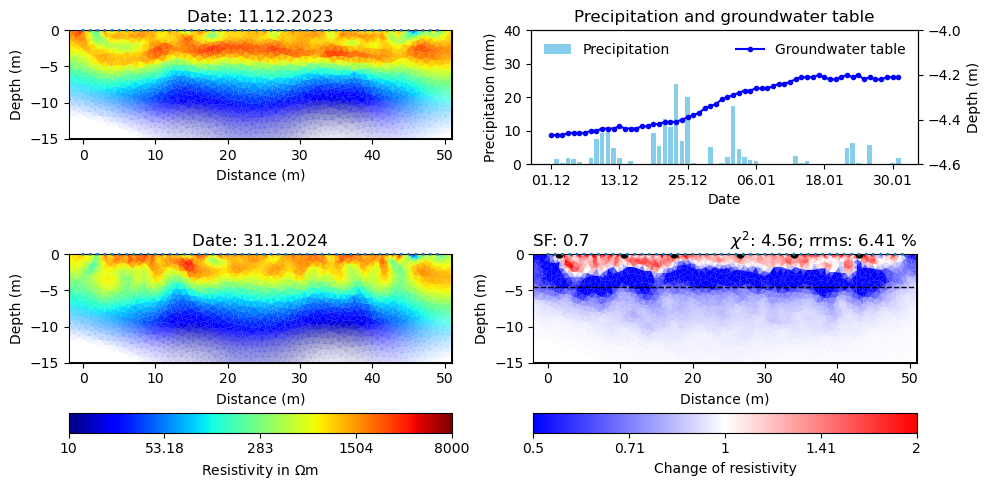

In [10]:
# Plot mit Niederschlag und Grundwasser für Paper
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
n = len(data)
fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(10,n*2.5))
plt.subplots_adjust(hspace=0.5)
axnr = -1
nrows=4
#axs[0, 1].axis('off')
modell = mod_Tcorr
test= True

for counter, (dat, res) in enumerate(zip(data, modell)):
    abzug = -1
    axnr = axnr +1
    row_index = counter*2
    datum = datetime.strptime(dat[0].split('_')[0], '%y%m%d')
    print(axnr)
    bild1 = manager[0].showResult(model = res, coverage = manager[0].coverage(),
            cMin=10, cMax=8000, logScale=True, cMap= 'jet', ax=axs[axnr, 0], label = 'Resistivity in $\Omega$m')
#    pg.show(pd,res,
#            cMin=10, cMax=1000, logScale=True, cMap= 'jet', ax = axs[axnr], label = 'Resistivity in $\Omega$m')
    axs[axnr, 0].set_title('Date: '+ str(datum.day) + '.' + str(datum.month) + '.' + str(datum.year))
    
    if axnr < len(axs)-1:
        cb = bild1[-1]
        cb.remove()
    
    if res[10] != modell[0][10]: # ab zweitem Bild
        #axnr = axnr +1
        ratio = res / modell[counter+abzug]
#        pg.show(mgr.mesh,ratio,
#                cMin=-50, cMax=50, cMap= 'bwr', ax= axs[axnr], label = 'Resistivity change in %')
        bild2 = manager[0].showResult(model= ratio,coverage = manager[0].coverage(),
                cMin=1/2, cMax=2, cMap= 'bwr', ax= axs[axnr, 1], label = 'Change of resistivity', logScale= True)
        if test == True:
            axs[axnr, 1].set_title('$\chi^2$: '+ str(chi2[0]) + '; rrms: '+ str(rrms[0])+ ' %',  loc = 'right')
            axs[axnr, 1].set_title('SF: '+ str(scalef), loc = 'left')
            test = False 
        if axnr < len(axs)-1:
            cb = bild2[-1]
            cb.remove()    
        # Prinzenpark
        axs[axnr, 1].plot(1.5,0, '.', markersize = '10', color = 'black')
        axs[axnr, 1].plot(10.5,0, '.', markersize = '10', color = 'black')
        axs[axnr, 1].plot(17.5,0, '.', markersize = '10', color = 'black')
        axs[axnr, 1].plot(26.5,0, '.', markersize = '10', color = 'black')
        axs[axnr, 1].plot(34,0, '.', markersize = '10 ', color = 'black')
        axs[axnr, 1].plot(43,0, '.', markersize = '10 ', color = 'black')
        axs[axnr, 1].set_ylim(-15, 0) 
        #axs[axnr, 1].axhline(y=-3.5, color='grey', linewidth = 0.5, linestyle='--', )
        #axs[axnr, 1].axhline(y=-5.5, color='grey', linewidth = 0.5, linestyle='--', )
        axs[axnr, 1].axhline(y=-4.5, color='k', linewidth = 1,linestyle='--')
for ax in axs:
    ax[0].set_xlabel('Distance (m)')
    ax[0].set_ylabel('Depth (m)')
    ax[1].set_xlabel('Distance (m)')
    ax[1].set_ylabel('Depth (m)')

# Balkendiagramm erstellen
data2 = pd.read_csv(r'./Precipitation_and_groundwater_data/Precipitation.csv')
data2['category'] = data2['category'].apply(lambda x: x.split(' ', 1)[1])
#data2['category'] = pd.to_datetime(data2['category']+ '2024', format='%d.%m.%Y')

# Funktion, um das Jahr entsprechend zu setzen
def set_year(date_str):
    month_day = pd.to_datetime(date_str + '2024', format='%d.%m.%Y')  # Setze standardmäßig auf 2024
    if month_day.month == 12:  # December
        return month_day.replace(year=2023)  # Setze Jahr auf 2023
    return month_day  # Für andere Monate bleibt es 2024
# Anwendung der Funktion auf die 'category'-Spalte
data2['category'] = data2['category'].apply(set_year)
tick_positions = range(0, len(data2['category']), 5)
axs[0, 1].bar(data2['category'], data2['Niederschlag (6 bis 6 UTC)'], color='skyblue', label = 'Precipitation')
axs[0, 1].set_ylim(0,40)
axs[0,1].set_title('Precipitation and groundwater table')
#axs[0, 1].title('Niederschlag von 6 bis 6 UTC')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Precipitation (mm)')
axs[0, 1].legend(frameon=False, shadow=False, loc = 'upper left')
axs[0, 1].xaxis.set_major_locator(DayLocator(interval=12))  # Setzt xticks alle 10 Tage
axs[0, 1].xaxis.set_major_formatter(DateFormatter('%d.%m'))  # Formatiert das Datum ohne Jahr

# Hinzufügen der Colorbar
norm = Normalize(vmin=0, vmax=25)
sm = ScalarMappable(cmap='viridis', norm=norm)
cbar = plt.colorbar(sm, ax=axs[0, 1],orientation='horizontal', pad = 0.1)
cbar2 = plt.colorbar(sm, ax=axs[0, 1], pad = -0.1)
cbar3 = plt.colorbar(sm, ax=axs[0, 1], location = 'left', pad = -0.1)
cbar.remove()
cbar2.remove()
cbar3.remove()
cbar.set_label('Example Colorbar (Units)')

# Zweite Achse für Grundwassertiefe
df = pd.read_csv(r'./Precipitation_and_groundwater_data/Grundwasserstaende.csv', delimiter=';', decimal=',')
df['Grundwasserstand'] = -df['Gelaendehoehe'] + df['GW-Stand ( m NN )']
sensor_data = df[df['Meßstelle'] == 'AW-216']
sensor_data['Meßdatum'] = pd.to_datetime(sensor_data['Meßdatum'], format='%d.%m.%Y')

start_date = '2023-12-01'
end_date = '2024-01-31'
filtered_data = sensor_data[(sensor_data['Meßdatum'] >= start_date) & (sensor_data['Meßdatum'] <= end_date)]
filtered_data = filtered_data.sort_values('Meßdatum')

# Plot auf zweiter Achse für Grundwassertiefe
ax2 = axs[0, 1].twinx()
ax2.plot(filtered_data['Meßdatum'], filtered_data['Grundwasserstand'], marker='.', color='blue', label = 'Groundwater table')
ax2.set_ylabel('Depth (m)')
ax2.set_ylim(-4.6, -4)
ax2.legend(frameon=False, shadow=False)

plt.tight_layout()

isExist = os.path.exists('./Fig15/' )
if not isExist:
    os.makedirs('./Fig15/')

fig.savefig('./Fig15/' + 'Groundwater_with_precipitation_and_groundwater.png', bbox_inches = 'tight', dpi=300)
